# Projeto 2 - NLP


O segundo projeto do módulo de Machine Learning será focado no processamento de linguagem natural! Usaremos os algoritmos aprendidos e as técnicas vistas na segunda parte do curso para extrairmos informações relevantes de texto. Mais precisamente, de publicações no Twitter.

## Os Dados

Utilizaremos um Dataset obtido do Twitter com 100K postagens entre os dias 01/08/2018 e 20/10/2018. Cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Dois arquivos serão disponilizados para o desenvolvimento dos modelos, um para treino/validação e outro para submissão. Os arquivos se encontram na pasta */Dados/train* e */Dados/subm*, respectivamente.

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

## O Problema

Você deverá desenvolver um modelo para detectar o sentimento de uma publicação do Twitter a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text". Teste e compare a melhor técnica para o processamento do texto e escolha a métrica de avaliação que julgar mais pertinente.  

Escolha o melhor modelo e pratique simular novas previsões utilizando uma base a partir dos dados de submissão, que estão no caminho ```Dados/subm/Subm3Classes.csv```.

In [1]:
# Importando as bibliotecas necessárias para o projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from pprint import pprint

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Edson-
[nltk_data]     Doris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Edson-
[nltk_data]     Doris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Desativando "warnings" temporariamente para execução do modelo 'XGBoosting'
warnings.filterwarnings('ignore')

In [3]:
# Carregando o 'DataFrame' referente à base de dados de "tweets"
df_tweets = pd.read_csv('Train3Classes.csv')

---

## Análise de consistência dos dados

In [4]:
# Visualizando as primeiras linhas do 'DataFrame'
df_tweets.head(10)

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)
5,1046774830857695232,@ppolkiss Parabéns moço :D,Mon Oct 01 14:52:22 +0000 2018,1,:)
6,1032054856712945664,Trago verdades #fato https://t.co/DsbkrJgFVj,Wed Aug 22 00:00:27 +0000 2018,2,#fato
7,1046740081090981889,"A coleção aumentou, mas o espaço do quaro ""dim...",Mon Oct 01 12:34:17 +0000 2018,1,:)
8,1046768079349403648,@abreujaviera Amigaa :(,Mon Oct 01 14:25:32 +0000 2018,0,:(
9,1046760775182888961,fiquei exatos 45 minutos tentando conectar meu...,Mon Oct 01 13:56:31 +0000 2018,1,:)


In [5]:
# Visualizando informações do 'DataFrame'
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


**OBS**: apenas confirmando informação divulgada na descrição do projeto, a "target" ('sentiment') já está como uma variável numérica qualitativa, formato necessário para aplicação dos futuros modelos de classificação.

In [6]:
# Visualizando as métricas das "features" numéricas do 'DataFrame' para verificação de consistência dos dados
df_tweets.describe()

,id,sentiment
count,9.500000e+04,95000.000000
mean,1.045740e+18,0.999263
std,4.259084e+15,0.816427
min,1.027374e+18,0.000000
25%,1.045370e+18,0.000000
50%,1.046827e+18,1.000000
75%,1.049106e+18,2.000000
max,1.053355e+18,2.000000


In [7]:
# Verificando se existem dados faltantes
df_tweets.isnull().sum()

id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

In [8]:
# Verificando se existem dados duplicados
df_tweets.loc[ df_tweets.duplicated() ]

,id,tweet_text,tweet_date,sentiment,query_used


**OBS**: a base de dados possui apenas duas "features" com valores do tipo numérico, sendo uma delas somente o "id" das mensagens e outra a "target", ao analisar essa nota-se que a mesma não possui inconsistência nos dados (valores abaixo de 0 ou acima de 2), ou seja, todos os registros possuem "targets" válidas. Ainda sobre essa base de dados, não existem dados faltantes ou duplicados. Sendo assim, não há necessidade de tratamento no "DataFrame" em relação à esses casos.

In [9]:
# Verificando se a quantidade de registros com a 'feature' "query_used" com o valor :) é igual à "target" com valor 1 (positivo) 
print('Quantidade de registros com o "query_used" valor :) =', df_tweets.loc[ df_tweets['query_used'] == ':)' ]['sentiment'].count())
print('Quantidade de registros com a target ("sentiment") valor 1 =', df_tweets.loc[ df_tweets['sentiment'] == 1 ]['sentiment'].count())

Quantidade de registros com o "query_used" valor :) = 31678
Quantidade de registros com a target ("sentiment") valor 1 = 31678


In [10]:
# Verificando se a quantidade de registros com a 'feature' "query_used" com o valor :( é igual à "target" com valor 0 (negativo) 
print('Quantidade de registros com o "query_used" valor :( =', df_tweets.loc[ df_tweets['query_used'] == ':(' ]['sentiment'].count())
print('Quantidade de registros com a target ("sentiment") valor 0 =', df_tweets.loc[ df_tweets['sentiment'] == 0 ]['sentiment'].count())

Quantidade de registros com o "query_used" valor :( = 31696
Quantidade de registros com a target ("sentiment") valor 0 = 31696


In [11]:
# Separando algumas amostras para verificar alguma característica que possa enviesar os futuros modelos
display(df_tweets.loc[ df_tweets['query_used'] == ':)' ].sample(frac=0.10))
display(df_tweets.loc[ df_tweets['query_used'] == ':)' ].sample(frac=0.10))
display(df_tweets.loc[ df_tweets['query_used'] == ':)' ].sample(frac=0.10))

,id,tweet_text,tweet_date,sentiment,query_used
6160,1047315157104447488,@ferques Sim :D achei q uma foto de mim atirad...,Wed Oct 03 02:39:26 +0000 2018,1,:)
14258,1048402169421029376,@GeiserGrace Irei testar Obrigada :),Sat Oct 06 02:38:50 +0000 2018,1,:)
7727,1049287510487179264,"@keillathg Não kkk só casa, séries, comida e c...",Mon Oct 08 13:16:51 +0000 2018,1,:)
16696,1047313439968911360,@TonhoDrinks @cor0te 9/10 pela lógica. :D,Wed Oct 03 02:32:36 +0000 2018,1,:)
94228,1045420665598353408,"@_mmiranda_ Kkkkkk DUVIDO q me dês, mas faço a...",Thu Sep 27 21:11:24 +0000 2018,1,:)
...,...,...,...,...,...
36581,1049317063829991430,Da pena de ver :),Mon Oct 08 15:14:18 +0000 2018,1,:)
24009,1049139479682981889,@kaduvrp I can't explain... Falei de drogas ma...,Mon Oct 08 03:28:38 +0000 2018,1,:)
58998,1049230739705876481,Bom dia a todas e a todos :),Mon Oct 08 09:31:16 +0000 2018,1,:)
54961,1049247322318786560,e parabéns pra mim q mordi o outro lado da lin...,Mon Oct 08 10:37:10 +0000 2018,1,:)


,id,tweet_text,tweet_date,sentiment,query_used
53811,1049105932284821506,@thfreitas_ @mauriciould Eleitor da Dilma nunc...,Mon Oct 08 01:15:20 +0000 2018,1,:)
43341,1049290165280301056,@Shinimon14 Ai é god pra treinar reflexos :P,Mon Oct 08 13:27:24 +0000 2018,1,:)
37914,1049245782749184005,@rafael_mafra @Deezer Pede pro @gugamafra mont...,Mon Oct 08 10:31:03 +0000 2018,1,:)
44361,1045420701518368774,@dirvitcom Participando :),Thu Sep 27 21:11:32 +0000 2018,1,:)
46392,1049107836029034498,Mandem perguntinhas :) https://t.co/PwOk5xYq31,Mon Oct 08 01:22:54 +0000 2018,1,:)
...,...,...,...,...,...
71417,1045394271468163072,@negowebber @NetflixBrasil Entre em contato co...,Thu Sep 27 19:26:31 +0000 2018,1,:)
88217,1049171293575118848,"@maiemaieme Sobra, Maie. :D",Mon Oct 08 05:35:03 +0000 2018,1,:)
36926,1046739593436033029,belo dia pra morrer :),Mon Oct 01 12:32:21 +0000 2018,1,:)
1418,1049291258060005376,@nicolinonez1 eu me esforçava muito pra ser um...,Mon Oct 08 13:31:45 +0000 2018,1,:)


,id,tweet_text,tweet_date,sentiment,query_used
92504,1045481206010335233,@fokdatson tomara que te chova em cima e que f...,Fri Sep 28 01:11:58 +0000 2018,1,:)
27433,1046778004918226944,"@polirangers É isso aí, dessa lista eu já te d...",Mon Oct 01 15:04:59 +0000 2018,1,:)
9170,1045431796916195331,@beeptozixr ai obrigada pelo link aaaa :),Thu Sep 27 21:55:38 +0000 2018,1,:)
91256,1047472527914795009,@Andress98278551 oi! Segue eu aki por gentilez...,Wed Oct 03 13:04:46 +0000 2018,1,:)
11916,1047469183624237067,Adoro o facto de todas as minhas amizades anti...,Wed Oct 03 12:51:29 +0000 2018,1,:)
...,...,...,...,...,...
29708,1047330032618823681,Falta mais 6 :),Wed Oct 03 03:38:32 +0000 2018,1,:)
30814,1047048676454125569,#Play #QuintoCanal ► Música do dia: #AVEC - #U...,Tue Oct 02 09:00:32 +0000 2018,1,:)
77815,1049238386698067969,Bom dia pra vocês.. :),Mon Oct 08 10:01:39 +0000 2018,1,:)
59197,1045435253614104576,@diogosoares_02 @traguedo2 @2cool_4u_ Vais ter...,Thu Sep 27 22:09:22 +0000 2018,1,:)


In [12]:
# Separando algumas amostras para verificar alguma característica que possa enviesar os futuros modelos
display(df_tweets.loc[ df_tweets['query_used'] == ':(' ].sample(frac=0.10))
display(df_tweets.loc[ df_tweets['query_used'] == ':(' ].sample(frac=0.10))
display(df_tweets.loc[ df_tweets['query_used'] == ':(' ].sample(frac=0.10))

,id,tweet_text,tweet_date,sentiment,query_used
3252,1049273499116814337,"@callmeshimina eu to bem triste, eu quero ir e...",Mon Oct 08 12:21:11 +0000 2018,0,:(
62317,1049139182273220608,eu não sei como vou dormir hoje :( https://t.c...,Mon Oct 08 03:27:27 +0000 2018,0,:(
2690,1046679648342552576,"@KleissonGDA @euandrewillis Perdi, bicho :( Vo...",Mon Oct 01 08:34:09 +0000 2018,0,:(
38960,1046716612852817920,@glokiburi Ostras!!! :(,Mon Oct 01 11:01:02 +0000 2018,0,:(
9957,1047062281530593281,"seola ta mandando boas energias, mesmo doentia...",Tue Oct 02 09:54:36 +0000 2018,0,:(
...,...,...,...,...,...
32809,1046987636504702977,eae qnd vamos da um role numa pracinha qualque...,Tue Oct 02 04:57:59 +0000 2018,0,:(
75184,1046972130179600384,🐝 viviheon. thats it. thats the tweet. meu nen...,Tue Oct 02 03:56:22 +0000 2018,0,:(
57975,1049286729608454144,@gmsantoss @Vinirstg Porra por isso que o amoe...,Mon Oct 08 13:13:45 +0000 2018,0,:(
7225,1046931427701477377,vai volta pro s3 quando mulhe??? sdds bora fum...,Tue Oct 02 01:14:38 +0000 2018,0,:(


,id,tweet_text,tweet_date,sentiment,query_used
10835,1049300207442309120,Tenho ainda tanto p fazer hoje e só quero fica...,Mon Oct 08 14:07:19 +0000 2018,0,:(
56552,1049139403296321541,@Carpe_DiemRK arrasada é pouco :( eu tô aos pr...,Mon Oct 08 03:28:20 +0000 2018,0,:(
37357,1046743749370499075,@analindimais A minha miopia voltou quase inte...,Mon Oct 01 12:48:52 +0000 2018,0,:(
3931,1049168422276349952,gnt eu juro que eu queria sair correndo do aca...,Mon Oct 08 05:23:39 +0000 2018,0,:(
77428,1049138940253487104,@626TN Eu sou lerda demais... A unha tá muito ...,Mon Oct 08 03:26:30 +0000 2018,0,:(
...,...,...,...,...,...
45470,1047047701525909505,Minha migs dodoi menparte o coração :(,Tue Oct 02 08:56:39 +0000 2018,0,:(
26668,1046766709133246470,A bicha ainda tem que terminar a agenda de sho...,Mon Oct 01 14:20:06 +0000 2018,0,:(
88754,1049314492893548550,@haurensflower @HarielFilipe vergonha do meu e...,Mon Oct 08 15:04:05 +0000 2018,0,:(
56978,1046679324458455040,"Já estou farta de estar aqui, quero a minha ma...",Mon Oct 01 08:32:51 +0000 2018,0,:(


,id,tweet_text,tweet_date,sentiment,query_used
74630,1046731607078506497,Queria eu participar do Inktober mas sem ideia...,Mon Oct 01 12:00:37 +0000 2018,0,:(
5807,1047032819183230976,Tá tocando sertanejo na Dammam e eu fico vomo ...,Tue Oct 02 07:57:31 +0000 2018,0,:(
1923,1046982599930011648,tô com tanta saudade do meu amor moreno :( tô ...,Tue Oct 02 04:37:58 +0000 2018,0,:(
75264,1049230492095197184,"To tao triste, mas tão triste que quando acord...",Mon Oct 08 09:30:17 +0000 2018,0,:(
229,1047001821045239808,"oi moça, boa noite, desculpa o incomodo mas se...",Tue Oct 02 05:54:21 +0000 2018,0,:(
...,...,...,...,...,...
40372,1049310662671917056,ngm acredita em mim :( https://t.co/83Io0OBIQi,Mon Oct 08 14:48:51 +0000 2018,0,:(
43416,1046963040367927301,@dearjdinah não se vá meu amor :(,Tue Oct 02 03:20:15 +0000 2018,0,:(
58097,1049140133298094080,@delucca 20 milhões não compareceram :(,Mon Oct 08 03:31:14 +0000 2018,0,:(
20552,1047047435678375936,Sobra. :(( https://t.co/wCfkBH3zHC,Tue Oct 02 08:55:36 +0000 2018,0,:(


Filtrando e analisando os registros com textos possuindo o símbolo **:)** como valor no atributo "query_used", podemos perceber que muitos deles possuem "emojis" relacionados ao sentimento de felicidade. Sendo esse um fato que proporcionaria um enviesamento em futuros modelos de predição, pois a pessoa poderia escrever um texto com sentimento negativo e inserir ironicamente um "smile" (emoji de sorriso) no final do mesmo, por exemplo.  

O mesmo acontece nos registros que apresentam textos com o símbolo **:(** no atributo citado em relação ao sentimento de tristeza, podendo influenciar o futuro modelo onde alguém poderia escrever um texto com sentimento positivo e inserir ironicamente um emoji triste no final do mesmo.

- **OBS**: a feature de consulta "query_used" está consistente em relação aos dados, pois as quantidades de resultados das consultas com os símbolos descritos acima estão de acordo com a "target" referentes aos mesmos, ou seja, a quantidade de "sentiment" 0 é igual a **:(** e a de "sentiment" 1 é igual a **:)**.

---

## Análise exploratória (EDA) {"parte 1"}

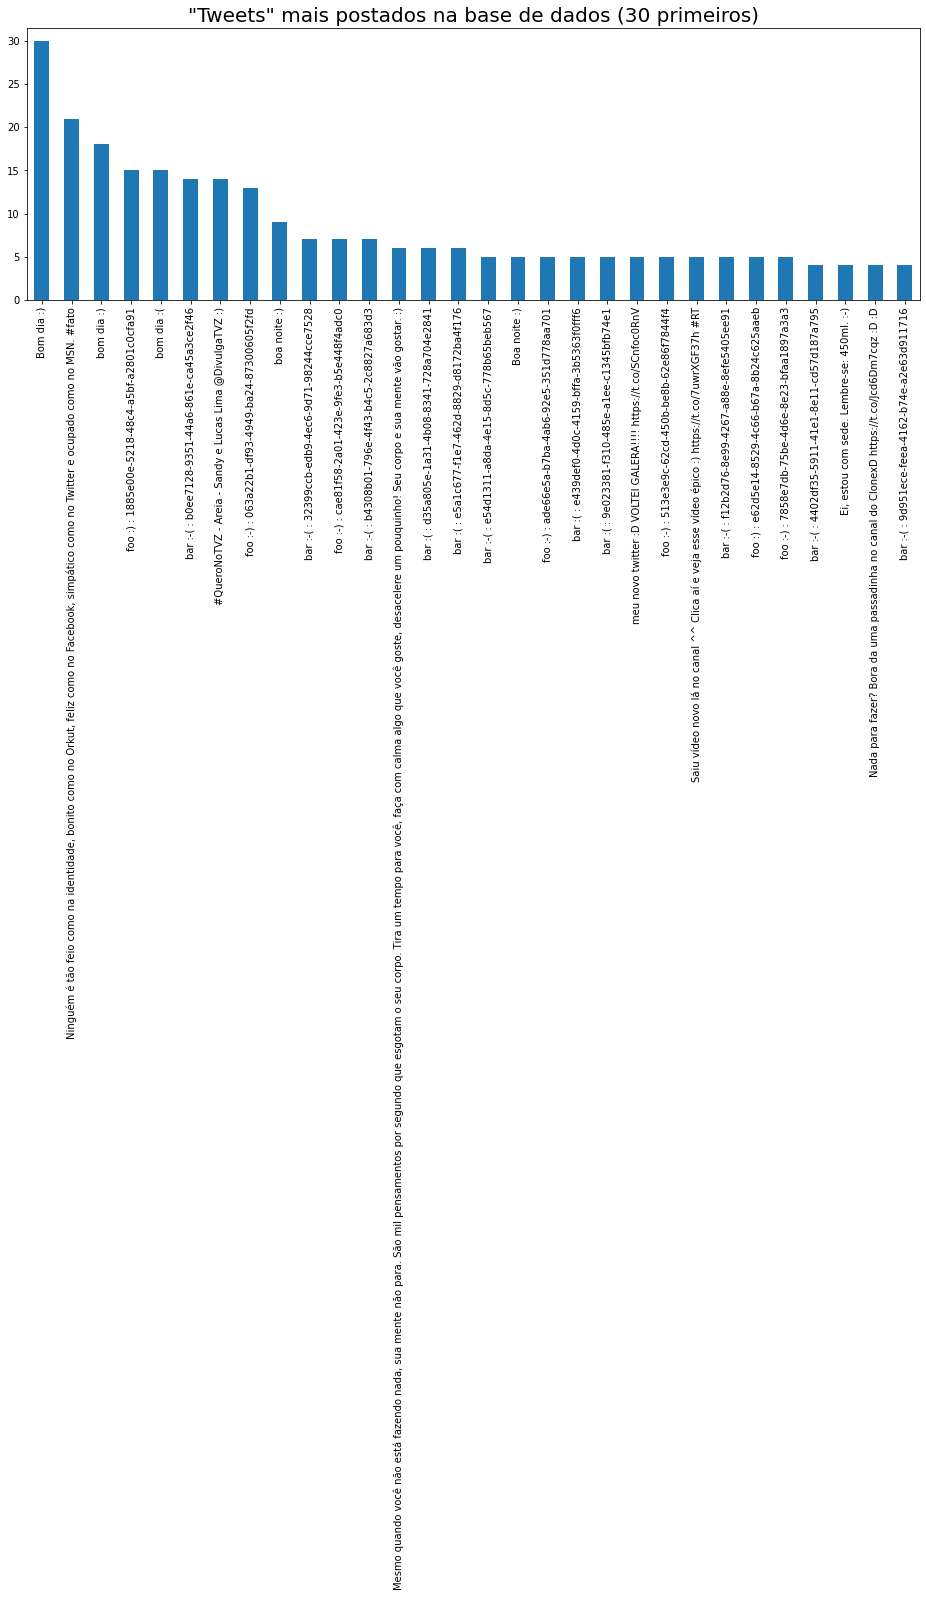

In [13]:
# Criando gráfico de barras para visualizar os textos mais postados na base de dados
plt.figure(figsize=(16, 5))
plt.title('"Tweets" mais postados na base de dados (30 primeiros)', fontdict={'fontsize': 20})
df_tweets['tweet_text'].value_counts().head(30).plot(kind='bar')
plt.show()

- Podemos observar que sem o pré-processamento dos textos, as postagens mais frequentes não retornam resultados muito relevantes para obter informações de análise de sentimentos ou desenvolver algum modelo de predição. Também é possível perceber a existência de palavras alfanuméricas desconhecidas, não sendo útil para obter alguma informação ou auxiliar no treinamento dos futuros modelos.

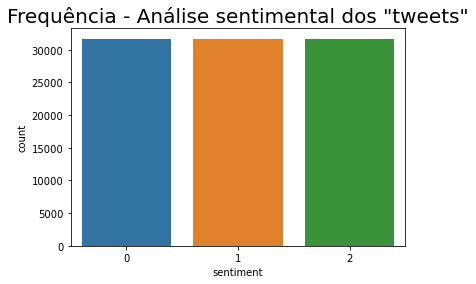

Percentual das frequências identificadas no gráfico:


0    0.333642
1    0.333453
2    0.332905
Name: sentiment, dtype: float64

In [14]:
# Criando gráfico de barras 'countplot' para analisar a proporção dos frequências referentes aos valores de 'target' ('sentiment')
plt.title('Frequência - Análise sentimental dos "tweets"', fontdict={'fontsize': 20})
sns.countplot(x=df_tweets['sentiment'])
plt.show()

# Calculando os percentuais das frequências do gráfico acima
print('\033[1mPercentual das frequências identificadas no gráfico:')
df_tweets['sentiment'].value_counts(normalize=True)

- Os dados relacionados à "target" estão balanceados, inclusive em uma proporção praticamente igual para cada resultado, conforme o gráfico acima. Sendo assim, não haverá a necessidade de efetuar algum rebalanceamento de dados para futuros modelos de predição.

In [15]:
# Quantidade de cada resultado da target para os 30 registros com mais frequencia na base de dados
for i in range(0, 30):
    print('Texto:', df_tweets['tweet_text'].value_counts().head(30).index[i])
    print('Res. Qtd.')
    print(df_tweets.loc[ df_tweets['tweet_text'] == df_tweets['tweet_text'].value_counts().head(30).index[i] ]['sentiment'].value_counts(), '\n')

Texto: Bom dia :)
Res. Qtd.
1    30
Name: sentiment, dtype: int64 

Texto: Ninguém é tão feio como na identidade, bonito como no Orkut, feliz como no Facebook, simpático como no Twitter e ocupado como no MSN. #fato
Res. Qtd.
2    21
Name: sentiment, dtype: int64 

Texto: bom dia :)
Res. Qtd.
1    18
Name: sentiment, dtype: int64 

Texto: foo :) : 1885e00e-5218-48c4-a5bf-a2801c0cfa91
Res. Qtd.
1    15
Name: sentiment, dtype: int64 

Texto: bom dia :(
Res. Qtd.
0    15
Name: sentiment, dtype: int64 

Texto: bar :-( : b0ee7128-9351-44a6-861e-ca45a3ce2f46
Res. Qtd.
0    14
Name: sentiment, dtype: int64 

Texto: #QueroNoTVZ - Areia - Sandy e Lucas Lima @DivulgaTVZ :)
Res. Qtd.
1    14
Name: sentiment, dtype: int64 

Texto: foo :-) : 063a22b1-df93-4949-ba24-87300605f2fd
Res. Qtd.
1    13
Name: sentiment, dtype: int64 

Texto: boa noite :)
Res. Qtd.
1    9
Name: sentiment, dtype: int64 

Texto: bar :-( : 32399ccb-edb9-4ec6-9d71-98244cce7528
Res. Qtd.
0    7
Name: sentiment, dtype: int64 

Tex

- Conforme o resultado gerado, a maioria deles são de sentimento positivo (17 dos 30).

Apesar dessa breve exploração dos dados, os resultados obtidos ainda não foram satisfatórios. Sendo assim, a opção para melhorar a EDA do projeto será aplicar o pré-processamento e transformações nos dados antes dar continuidade à mesma.

---

## Pré-processamento e transformações

In [16]:
## FUNÇÃO DE PRÉ-PROCESSAMENTO DOS TEXTOS ##

# Criando função 'executa_pre_process'
def executa_pre_process(string, idioma):
    '''Recebe duas variáveis do tipo "string", uma referente ao texto que deseja realizar o pré-processamento e outra referente ao idioma do texto. Executa o \
pré-processamento de textos na string informada, seguindo o idioma inserido como parâmetro (Obs: inserir idioma em inglês, conforme lista de idiomas disponíveis \
na biblioteca "SnowballStemmer".'''

    # Criando conjunto de palavras para remover das strings
    conj_stopwords = set(stopwords.words(idioma))

    # Removendo acentos das "strings" do 'DataFrame'
    string = unidecode(string)

    # 'Looping' para remover os acentos das palavras do conjunto de "stopwords"
    lista_stopwords = []
    for palavra in conj_stopwords:
        lista_stopwords.append(unidecode(palavra))
    # Alterando o tipo da variável para conjunto ('set')
    conj_stopwords = set(lista_stopwords)

    # Alterando todas as letras em minúsculas
    string = string.lower()

    # Removendo os links 'http' ou 'https'
    string = re.sub(r'\bhttp\S+', '', string)

    # Removendo os caracteres especiais (também os "emojis")
    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string)

    # Retirando da lista de 'stopwords' palavras que serão úteis para as análises do modelo
    rem_palavras = ['nao']
    for palavra in rem_palavras:
        conj_stopwords.remove(palavra)

    # Inserindo na lista de 'stopwords' palavras que não serão úteis para as análises do modelo (consideração após realizar o pré-processamento pela primeira vez)
    ins_palavras = ['d', 'p', 'q', 'n', 'ai']
    for palavra in ins_palavras:
        conj_stopwords.add(palavra)

    # Separando as palavras da "string" em uma lista de "palavras"
    lista_palavras = word_tokenize(string)
    
    # Removendo as palavras 'stopwords' dos textos de cada registro
    lista_palavras = [palavra for palavra in lista_palavras if palavra not in conj_stopwords]

    # Realizando o procedimento de 'Stemming' para normalização das palavras para um radical (ou o mais próximo possível) e 
    stemmer = SnowballStemmer('portuguese') # Instanciando classe para normalização das palavras
    lista_palavras = [stemmer.stem(palavra) for palavra in lista_palavras]
    
    return lista_palavras

In [17]:
# Criando nova coluna referente ao pré-processamento dos textos
df_tweets['filtering_text'] = df_tweets['tweet_text'].apply(lambda x: executa_pre_process(x, 'portuguese'))

# Criando uma nova coluna transformando as palavras do 'filtering_text' em uma única "string" para utilização nos modelos
df_tweets['join_text'] = df_tweets['filtering_text'].apply(lambda x: ' '.join(x))

In [18]:
# Visualizando os primeiros registros do 'DataFrame' após o pré-processamento e transformações
df_tweets.head()

,id,tweet_text,tweet_date,sentiment,query_used,filtering_text,join_text
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha,"[rio, eleg, maior, banc, policial, histor]",rio eleg maior banc policial histor
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(,"[fiqu, tao, trist, vi, prec, cam]",fiqu tao trist vi prec cam
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame,"[theres, may, plan, brexit, unic, opca]",theres may plan brexit unic opca
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(,"[caralh, quer, proteg, danielly, pot, tadinha]",caralh quer proteg danielly pot tadinha
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:),"[sicaetan, viv, caos]",sicaetan viv caos


- **OBS**: Após analisar algumas possibilidades de processamentos e transformações dos dados, foi escolhida a normalização "SnowballStemmer", pois ela proporcionou uma melhor normalização das palavras em seus radicais pensando nos futuros modelos de predições sentimentais dos textos.

---

## Análise exploratória (EDA) {"parte 2"}

Após o pré-processamento e transformações dos dados de textos, é possível realizar uma EDA mais rica, com mais informações e "insights" sobre o "dataset".

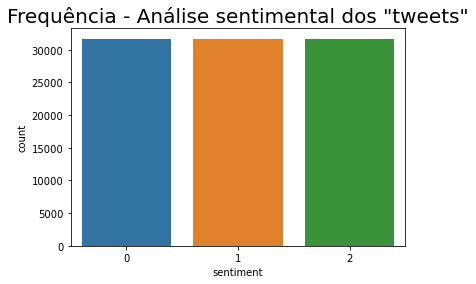

Percentual das frequências identificadas no gráfico:


0    0.333642
1    0.333453
2    0.332905
Name: sentiment, dtype: float64

In [19]:
## RELEMBRANDO O BALANCEAMENTO DOS VALORES DA 'TARGET' ##

# Criando gráfico de barras 'countplot' para analisar a proporção dos frequências referentes aos valores de 'target' ('sentiment')
plt.title('Frequência - Análise sentimental dos "tweets"', fontdict={'fontsize': 20})
sns.countplot(x=df_tweets['sentiment'])
plt.show()

# Calculando os percentuais das frequências do gráfico acima
print('\033[1mPercentual das frequências identificadas no gráfico:')
df_tweets['sentiment'].value_counts(normalize=True)

- **OBS**: como esperado, os dados relacionados aos valores da 'target' não sofreram alterações após o pré-processamento e transformações dos textos, sendo assim, os mesmos continuam balanceados.

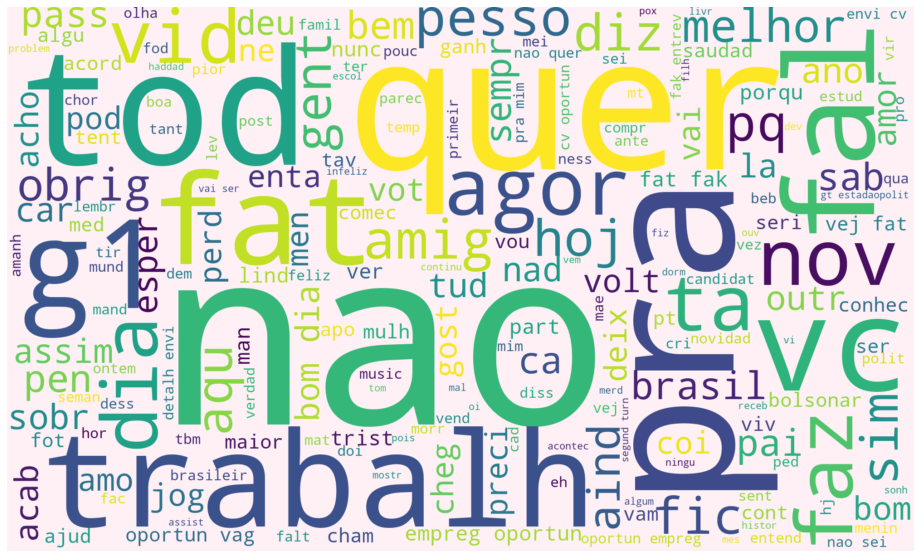

In [20]:
## WORDCLOUD - Radicais das palavras encontradas nos textos ##

# Criando lista com todas as palavras de todos os textos do 'DataFrame'
lista_strings = df_tweets['join_text']
lista_palavras = []
for string in lista_strings: # Cada string do 'DataFrame'
    string_split = string.split()
    for palavra in string_split: # Cada palavra da string
        lista_palavras.append(palavra)

# Gerando visualização 'Nuvem de Palavras (Wordcloud)' para observar as palavras com mais frequência nos textos
palavras_textos = ' '.join(lista_palavras)
wordcloud = WordCloud(width=2000, height=1200, margin=0, background_color='lavenderblush').generate(palavras_textos)
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

- **OBS**: com essa visualização podemos notar facilmente as palavras e radicais das palavras mais citadas nas postagens armazenadas no "dataset". À partir disso, é possível fazer obter melhores "insights", ideias, considerações e desenvolvimento de modelos do que antes do pré-processamento e transformação dos textos.

In [21]:
# Criando vocabulário para realização de outras análises
vocab_tweets = Counter(lista_palavras)
vocab_tweets

Counter({'rio': 864,
         'eleg': 188,
         'maior': 840,
         'banc': 282,
         'policial': 57,
         'histor': 580,
         'fiqu': 839,
         'tao': 2140,
         'trist': 1959,
         'vi': 611,
         'prec': 244,
         'cam': 426,
         'theres': 6,
         'may': 42,
         'plan': 293,
         'brexit': 41,
         'unic': 410,
         'opca': 146,
         'caralh': 298,
         'quer': 6400,
         'proteg': 90,
         'danielly': 3,
         'pot': 16,
         'tadinha': 2,
         'sicaetan': 1,
         'viv': 823,
         'caos': 40,
         'ppolkiss': 3,
         'parabens': 488,
         'moc': 112,
         'trag': 29,
         'verdad': 649,
         'fat': 3751,
         'coleca': 75,
         'aument': 267,
         'espac': 122,
         'quar': 1,
         'diminu': 64,
         'inviabiliz': 2,
         'nov': 2378,
         'fot': 984,
         'abreujavi': 1,
         'amiga': 10,
         'exat': 226,
         

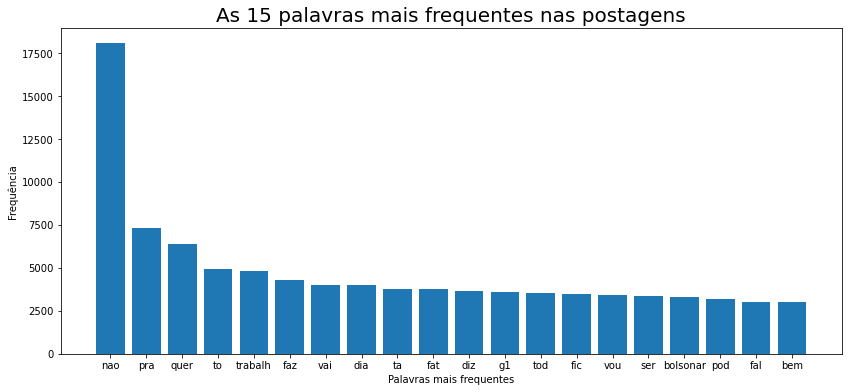

In [22]:
# Criando gráfico de barras para verificar as 15 palavras mais frequentes nas postagens da base de dados
df_freq_palavras = pd.DataFrame(vocab_tweets.most_common(n=20), columns=['Palavra', 'Freq'])
plt.figure(figsize=(14, 6))
plt.bar(df_freq_palavras['Palavra'], df_freq_palavras['Freq'])
plt.xlabel('Palavras mais frequentes')
plt.ylabel('Frequência')
plt.title('As 15 palavras mais frequentes nas postagens', fontdict={'fontsize': 20})
plt.show()

Palavra: nao
Res. Qtd.
0    7019
1    5755
2    2436
Name: sentiment, dtype: int64


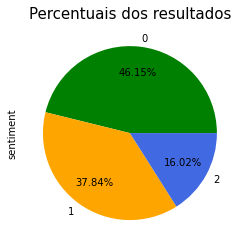

--------------------------------------------------
Palavra: pra
Res. Qtd.
1    3045
0    2984
2     460
Name: sentiment, dtype: int64


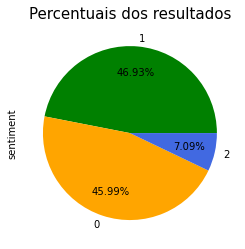

--------------------------------------------------
Palavra: quer
Res. Qtd.
0    3873
1    1574
2     684
Name: sentiment, dtype: int64


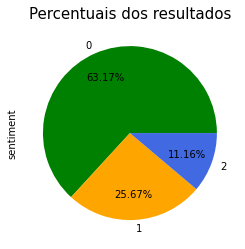

--------------------------------------------------
Palavra: to
Res. Qtd.
0    3276
1    1277
2      70
Name: sentiment, dtype: int64


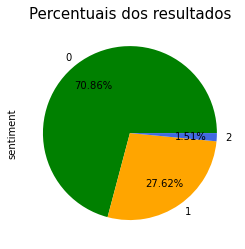

--------------------------------------------------
Palavra: trabalh
Res. Qtd.
2    3417
1     464
0     245
Name: sentiment, dtype: int64


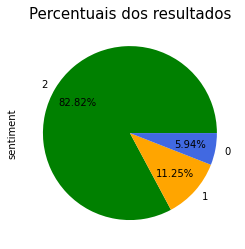

--------------------------------------------------
Palavra: faz
Res. Qtd.
1    1689
0    1389
2     980
Name: sentiment, dtype: int64


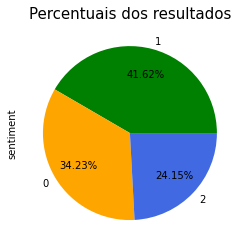

--------------------------------------------------
Palavra: vai
Res. Qtd.
1    1504
0    1339
2     889
Name: sentiment, dtype: int64


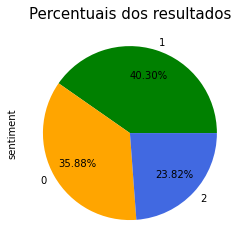

--------------------------------------------------
Palavra: dia
Res. Qtd.
1    1952
0     891
2     878
Name: sentiment, dtype: int64


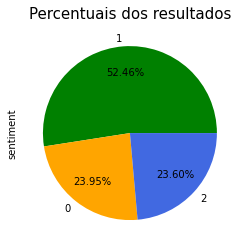

--------------------------------------------------
Palavra: ta
Res. Qtd.
0    1961
1    1423
2     124
Name: sentiment, dtype: int64


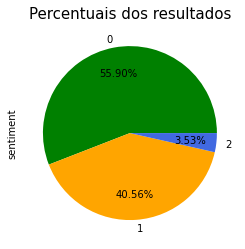

--------------------------------------------------
Palavra: fat
Res. Qtd.
2    3515
1      87
0      52
Name: sentiment, dtype: int64


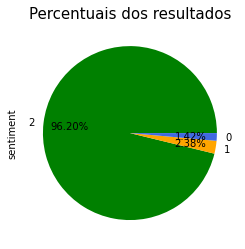

--------------------------------------------------
Palavra: diz
Res. Qtd.
2    2766
1     534
0     285
Name: sentiment, dtype: int64


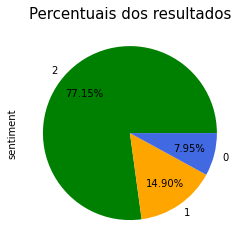

--------------------------------------------------
Palavra: g1
Res. Qtd.
2    3531
1      19
0       4
Name: sentiment, dtype: int64


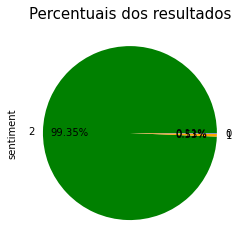

--------------------------------------------------
Palavra: tod
Res. Qtd.
1    1400
0    1213
2     731
Name: sentiment, dtype: int64


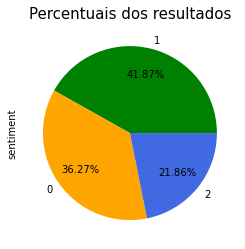

--------------------------------------------------
Palavra: fic
Res. Qtd.
0    1630
1    1293
2     428
Name: sentiment, dtype: int64


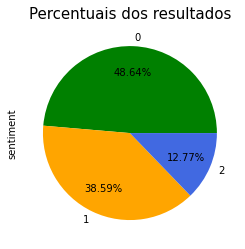

--------------------------------------------------
Palavra: vou
Res. Qtd.
1    1700
0    1405
2      85
Name: sentiment, dtype: int64


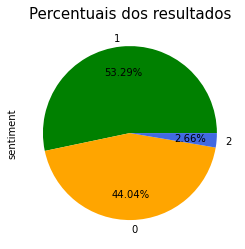

--------------------------------------------------
Palavra: ser
Res. Qtd.
1    1223
0    1045
2     875
Name: sentiment, dtype: int64


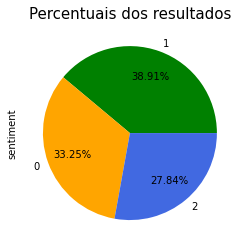

--------------------------------------------------
Palavra: bolsonar
Res. Qtd.
2    2819
1     307
0     155
Name: sentiment, dtype: int64


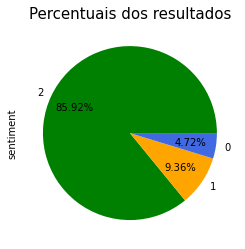

--------------------------------------------------
Palavra: pod
Res. Qtd.
1    1278
2     910
0     892
Name: sentiment, dtype: int64


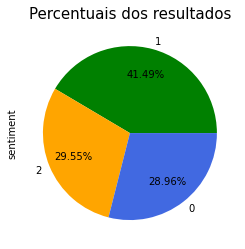

--------------------------------------------------
Palavra: fal
Res. Qtd.
1    1263
0     997
2     514
Name: sentiment, dtype: int64


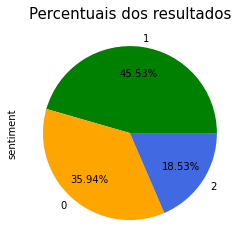

--------------------------------------------------
Palavra: bem
Res. Qtd.
1    1546
0    1020
2     277
Name: sentiment, dtype: int64


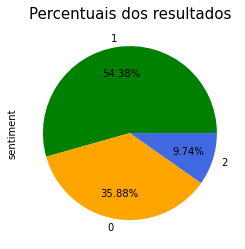

--------------------------------------------------


In [23]:
## Quantidade de cada resultado da 'target' com as 15 palavras mais frequentes ##

# 'Looping' para calcular as quantidades relacionadas a cada palavra
for palavra in df_freq_palavras['Palavra']:
    # Criando coluna temporária para identificar os registros que possuem a palavra
    df_tweets['possui_palavra'] = df_tweets['filtering_text'].apply(lambda x: 1 if palavra in x else 0)
    # Exibindo quantidades
    print(f'Palavra: {palavra}')
    print('Res. Qtd.')
    print(df_tweets.loc[ df_tweets['possui_palavra'] == 1 ]['sentiment'].value_counts())
    # Criando gráfico de pizza para visualizar os percentuais
    plt.title('Percentuais dos resultados', fontdict={'fontsize': 15})
    df_tweets.loc[ df_tweets['possui_palavra'] == 1 ]['sentiment'].value_counts().plot(kind='pie', colors=['g', 'orange', '#4169E1'], autopct='%1.2f%%', pctdistance=0.7)
    plt.show()
    print('-' * 50)

# Removendo coluna temporária 'possui_palavra'
df_tweets.drop(columns='possui_palavra', inplace=True)

- **OBS**: algumas das palavras mais frequentes são relevantes e nos dão uma ideia das expressões e assuntos mais comentados nas postagens armazenadas na base de dados, além do sentimento dos usuários aos postar textos utilizando as mesmas. Por outro lado também existem palavras que não são relevantes se observadas individualmente, mas serão úteis para o treinamento dos modelos de predição.

---

## Treinamento do modelo

### - Escolha do Modelo

Para o desenvolvimento e treinamento do modelo, serão utilizados alguns modelos e conforme o desempenho dos mesmos, será escolhido aquele que apresentar o melhor resultado de **acurária**. Esses procedimentos acontecerão em duas amostras de 20% da base, devido à grande quantidade de dados que a mesma possui, não sendo possível executar em tempo hábil com o recurso computacional disponível no momento. Os modelos serão testados com os dados recebendo dois tipos de transformações, utilizando as bibliotecas mais conhecidas: **CountVectorizer** e **TF-IDF**. Além do modelo, também será escolhido um dos métodos (bibliotecas) de transformação.


Seguem abaixo os modelos selecionados inicialmente:
- Adaboost
- Decision Tree
- LightGBM
- Naive Bayes
- Random Forest
- Regressão Logística
- XGBoosting

In [24]:
# Separando as duas amostras de 20% da base de dados
df_twe_amostra1 = df_tweets.sample(frac=0.20, random_state=8)
df_twe_amostra2 = df_tweets.sample(frac=0.20, random_state=90)

In [25]:
# Criando função para transformações 'CountVectorizer'
def transforma_cv(X_train, X_test):
    '''Recebe as variáveis de treino e teste e realiza a transformação dos dados utilizando a biblioteca "CountVectorizer".'''

    # Instanciando o 'CountVectorizer'
    cv = CountVectorizer()

    # Alterando formato dos dados para funcionar corretamente nos modelos
    X_train_cv = cv.fit_transform(X_train).toarray()
    X_test_cv = cv.transform(X_test).toarray()
    
    return X_train_cv, X_test_cv

In [26]:
# Criando função para transformações 'TF-IDF'
def transforma_tf_idf(X_train, X_test):
    '''Recebe as variáveis de treino e teste e realiza a transformação dos dados utilizando a biblioteca "TF-IDF".'''

    # Instanciando o 'TfidfVectorizer'
    tf_idf = TfidfVectorizer()

    # Alterando formato dos dados para funcionar corretamente nos modelos
    X_train_tf = tf_idf.fit_transform(X_train).todense()
    X_test_tf = tf_idf.transform(X_test).todense()
    
    return X_train_tf, X_test_tf

In [27]:
# Criando função para testar os modelos e visualizar suas métricas
def testa_modelo_exibe_metricas(lista_modelos, col_nome_modelo, col_modelo, X_train, X_test, y_train, y_test):
    '''Recebe uma lista com os nomes e instâncias dos modelos (lista_modelos), duas "strings": 1ª) os nomes das colunas referentes ao nome do modelo (col_nome_modelo) \
e ao próprio modelo em si (col_modelo). Recebe também as variáveis de treino e teste com os dados para a execução dos modelos relacionados na lista. Retorna a exibição \
das métricas: acurária, precisão, "recall", "f1-score" e "ROC-AUC" dos modelos e o gráfico da curva ROC-AUC dos mesmos.'''
    
    # 'Loop' para instanciar, treinar e realizar predições de cada modelo da lista
    for mod in lista_modelos:
        modelo = mod[col_modelo]
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)        
       
        # Exibindo "scores" dos modelos
        print('Modelo      : %s' % mod[col_nome_modelo])
        print(classification_report(y_test, y_pred))
        print('-' * 70)

#### CountVectorizer

**Amostra 1**

In [28]:
# Criando variáveis para separação de treino e teste
X = df_twe_amostra1['join_text']
y = df_twe_amostra1['sentiment']

In [29]:
# Criando variáveis para separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [30]:
# Criando variáveis com a transformação 'CountVectorizer' para aplicar nos modelos
X_train_cv, X_test_cv = transforma_cv(X_train, X_test)

In [31]:
# Criando lista de modelos (dicionários) selecionados para o desenvolvimento do projeto
random_seed = 8
lista_modelos = [
    {'nome_modelo': 'Adaboost', 'modelo': AdaBoostClassifier(random_state=random_seed)},
    {'nome_modelo': 'Decision Tree', 'modelo': DecisionTreeClassifier(random_state=random_seed)},
    {'nome_modelo': 'LightGBM', 'modelo': LGBMClassifier(random_state=random_seed)},
    {'nome_modelo': 'Naive-Bayes', 'modelo': GaussianNB()},
    {'nome_modelo': 'Random Forest', 'modelo': RandomForestClassifier(random_state=random_seed)},
    {'nome_modelo': 'Regressão Logística', 'modelo': LogisticRegression(max_iter=500, random_state=random_seed)},  
    {'nome_modelo': 'XGBoosting', 'modelo': XGBClassifier(random_state=random_seed)}
]

In [32]:
%%time
# Executando a função 'testa_modelo_exibe_metricas' para verificar o melhor modelo entre os selecionados inicialmente
testa_modelo_exibe_metricas(lista_modelos, 'nome_modelo', 'modelo', X_train_cv, X_test_cv, y_train, y_test)

Modelo      : Adaboost
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      1867
           1       0.53      0.72      0.61      1933
           2       0.90      0.77      0.83      1900

    accuracy                           0.67      5700
   macro avg       0.70      0.67      0.67      5700
weighted avg       0.70      0.67      0.67      5700

----------------------------------------------------------------------
Modelo      : Decision Tree
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1867
           1       0.61      0.58      0.59      1933
           2       0.86      0.87      0.87      1900

    accuracy                           0.70      5700
   macro avg       0.70      0.70      0.70      5700
weighted avg       0.70      0.70      0.70      5700

----------------------------------------------------------------------
Modelo      : LightGBM
              precisio

**Amostra 2**

In [33]:
# Criando variáveis para separação de treino e teste
X = df_twe_amostra2['join_text']
y = df_twe_amostra2['sentiment']

In [34]:
# Criando variáveis para separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [35]:
# Criando variáveis com a transformação 'CountVectorizer' para aplicar nos modelos
X_train_cv, X_test_cv = transforma_cv(X_train, X_test)

In [36]:
# Criando lista de modelos (dicionários) selecionados para o desenvolvimento do projeto
random_seed = 90
lista_modelos = [
    {'nome_modelo': 'Adaboost', 'modelo': AdaBoostClassifier(random_state=random_seed)},
    {'nome_modelo': 'Decision Tree', 'modelo': DecisionTreeClassifier(random_state=random_seed)},
    {'nome_modelo': 'LightGBM', 'modelo': LGBMClassifier(random_state=random_seed)},
    {'nome_modelo': 'Naive-Bayes', 'modelo': GaussianNB()},
    {'nome_modelo': 'Random Forest', 'modelo': RandomForestClassifier(random_state=random_seed)},
    {'nome_modelo': 'Regressão Logística', 'modelo': LogisticRegression(max_iter=500, random_state=random_seed)},  
    {'nome_modelo': 'XGBoosting', 'modelo': XGBClassifier(random_state=random_seed)}
]

In [37]:
%%time
# Executando a função 'testa_modelo_exibe_metricas' para verificar o melhor modelo entre os selecionados inicialmente
testa_modelo_exibe_metricas(lista_modelos, 'nome_modelo', 'modelo', X_train_cv, X_test_cv, y_train, y_test)

Modelo      : Adaboost
              precision    recall  f1-score   support

           0       0.65      0.49      0.56      1841
           1       0.53      0.71      0.61      2009
           2       0.90      0.77      0.83      1850

    accuracy                           0.66      5700
   macro avg       0.69      0.66      0.67      5700
weighted avg       0.69      0.66      0.66      5700

----------------------------------------------------------------------
Modelo      : Decision Tree
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1841
           1       0.63      0.55      0.58      2009
           2       0.77      0.87      0.82      1850

    accuracy                           0.68      5700
   macro avg       0.68      0.68      0.68      5700
weighted avg       0.67      0.68      0.68      5700

----------------------------------------------------------------------
Modelo      : LightGBM
              precisio

#### TF-IDF

**Amostra 1**

In [47]:
# Criando variáveis para separação de treino e teste
X = df_twe_amostra1['join_text']
y = df_twe_amostra1['sentiment']

# Criando variáveis para separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Criando variáveis com a transformação 'TfidfVectorizer' para aplicar nos modelos
X_train_tf, X_test_tf = transforma_tf_idf(X_train, X_test)

In [41]:
# Criando lista de modelos (dicionários) selecionados para o desenvolvimento do projeto
random_seed = 8
lista_modelos = [
    {'nome_modelo': 'Adaboost', 'modelo': AdaBoostClassifier(random_state=random_seed)},
    {'nome_modelo': 'Decision Tree', 'modelo': DecisionTreeClassifier(random_state=random_seed)},
    {'nome_modelo': 'LightGBM', 'modelo': LGBMClassifier(random_state=random_seed)},
    {'nome_modelo': 'Naive-Bayes', 'modelo': GaussianNB()},
    {'nome_modelo': 'Random Forest', 'modelo': RandomForestClassifier(random_state=random_seed)},
    {'nome_modelo': 'Regressão Logística', 'modelo': LogisticRegression(max_iter=500, random_state=random_seed)},  
    {'nome_modelo': 'XGBoosting', 'modelo': XGBClassifier(random_state=random_seed)}
]

In [42]:
%%time
# Executando a função 'testa_modelo_exibe_metricas' para verificar o melhor modelo entre os selecionados inicialmente
testa_modelo_exibe_metricas(lista_modelos, 'nome_modelo', 'modelo', X_train_tf, X_test_tf, y_train, y_test)

Modelo      : Adaboost
              precision    recall  f1-score   support

           0       0.66      0.50      0.57      1867
           1       0.53      0.72      0.61      1933
           2       0.90      0.78      0.84      1900

    accuracy                           0.67      5700
   macro avg       0.70      0.67      0.67      5700
weighted avg       0.70      0.67      0.67      5700

----------------------------------------------------------------------
Modelo      : Decision Tree
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1867
           1       0.59      0.58      0.59      1933
           2       0.87      0.85      0.86      1900

    accuracy                           0.69      5700
   macro avg       0.69      0.69      0.69      5700
weighted avg       0.69      0.69      0.69      5700

----------------------------------------------------------------------
Modelo      : LightGBM
              precisio

**Amostra 2**

In [40]:
# Criando variáveis para separação de treino e teste
X = df_twe_amostra2['join_text']
y = df_twe_amostra2['sentiment']

In [41]:
# Criando variáveis para separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [42]:
# Criando variáveis com a transformação 'TfidfVectorizer' para aplicar nos modelos
X_train_tf, X_test_tf = transforma_tf_idf(X_train, X_test)

In [43]:
# Criando lista de modelos (dicionários) selecionados para o desenvolvimento do projeto
random_seed = 90
lista_modelos = [
    {'nome_modelo': 'Adaboost', 'modelo': AdaBoostClassifier(random_state=random_seed)},
    {'nome_modelo': 'Decision Tree', 'modelo': DecisionTreeClassifier(random_state=random_seed)},
    {'nome_modelo': 'LightGBM', 'modelo': LGBMClassifier(random_state=random_seed)},
    {'nome_modelo': 'Naive-Bayes', 'modelo': GaussianNB()},
    {'nome_modelo': 'Random Forest', 'modelo': RandomForestClassifier(random_state=random_seed)},
    {'nome_modelo': 'Regressão Logística', 'modelo': LogisticRegression(max_iter=500, random_state=random_seed)},  
    {'nome_modelo': 'XGBoosting', 'modelo': XGBClassifier(random_state=random_seed)}
]

In [44]:
%%time
# Executando a função 'testa_modelo_exibe_metricas' para verificar o melhor modelo entre os selecionados inicialmente
testa_modelo_exibe_metricas(lista_modelos, 'nome_modelo', 'modelo', X_train_tf, X_test_tf, y_train, y_test)

Modelo      : Adaboost
              precision    recall  f1-score   support

           0       0.64      0.48      0.55      1841
           1       0.53      0.71      0.61      2009
           2       0.89      0.78      0.83      1850

    accuracy                           0.66      5700
   macro avg       0.69      0.66      0.66      5700
weighted avg       0.68      0.66      0.66      5700

----------------------------------------------------------------------
Modelo      : Decision Tree
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1841
           1       0.65      0.53      0.58      2009
           2       0.78      0.89      0.83      1850

    accuracy                           0.69      5700
   macro avg       0.68      0.69      0.69      5700
weighted avg       0.68      0.69      0.68      5700

----------------------------------------------------------------------
Modelo      : LightGBM
              precisio

### - Otimização do modelo escolhido

Visualizando e analisando os resultados, utilizando como principal critério de avaliação a **acurácia**, o modelo escolhido foi o **Regressão Logística** com a transformação de textos **TF-IDF**. Além da acurária, o modelo demonstrou melhores resultados também na maioria das demais métricas. Agora com o modelo selecionado, serão aplicadas as técnicas de otimização, buscando melhorar os resultados das métricas do mesmo (os passos a seguir acontecerão com a **Amostra 1**).

In [134]:
# Reduzindo tamanho da Amostra 1 para aplicar as técnicas de otimização (4% da base de dados)
df_twe_am1_red = df_tweets.sample(frac=0.04, random_state=8)

## Atualizando as variáveis de treino e teste com a Amostra 1 reduzida e transformação de texto 'TF-IDF'

# Criando variáveis para separação de treino e teste
X = df_twe_am1_red['join_text']
y = df_twe_am1_red['sentiment']

# Criando variáveis para separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Criando variáveis com a transformação 'TfidfVectorizer' para aplicar nos modelos
X_train_tf, X_test_tf = transforma_tf_idf(X_train, X_test)

# Instanciando o modelo 'Regressão Logística'
random_seed = 8
modelo = LogisticRegression(max_iter=500, random_state=random_seed)

In [135]:
# Verificando parâmetros disponíveis para aplicar otimização
pprint(modelo.get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [136]:
# Criando variáveis referentes aos hiperparâmetros selecionados para otimização
C = [x for x in np.linspace(0.5, 5.0, 10)]
tol = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01]
solver = ['newton-cg', 'lbfgs', 'liblinear']

# Armazenando variáveis em um dicionário
parametros_dic = {'C': C,
                  'tol': tol,
                  'solver': solver
}

# Instanciando a classe 'RandomizedSearchCV' para pesquisar as configurações de parâmetros mais indicadas para possível melhoria de resultados do modelo
param_aleatorios = RandomizedSearchCV(estimator=modelo, param_distributions=parametros_dic, n_iter=100, random_state=8, n_jobs=-1, cv=3, verbose=2)

In [137]:
%%time
# Aplicando treino na instância do 'RandomizedSearchCV' com os dados de treino do "dataset" para obter os valores de parâmetros mais indicados para o modelo
param_aleatorios.fit(X_train_tf, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 6min 8s


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=500, random_state=8),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
                                              4.0, 4.5, 5.0],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear'],
                                        'tol': [0.0001, 0.00025, 0.0005,
                                                0.00075, 0.001, 0.0025, 0.005,
                                                0.0075, 0.01]},
                   random_state=8, verbose=2)

In [140]:
# Verificando se o modelo está propenso à 'underfitting' ou 'overfitting'
print(param_aleatorios.cv_results_['mean_test_score'], '\n')
print('Média das pontuações de "mean_test_score" do "cross-validation":', param_aleatorios.cv_results_['mean_test_score'].mean())
print('De acordo com os resultados, o modelo está aprendendo quando recebe novos dados, sem propensões para "underfitting" ou "overfitting".')

[0.72782004 0.72970158 0.73157887 0.72594104 0.72631727 0.72819668
 0.72894743 0.72669349 0.72819626 0.7297003  0.72970158 0.7297003
 0.72744551 0.72631727 0.72744339 0.72669264 0.72782089 0.72894786
 0.72744466 0.72669349 0.72744466 0.72782131 0.72669349 0.72706802
 0.72669349 0.72894743 0.72706844 0.72631727 0.72857163 0.72744466
 0.73157887 0.72669349 0.72669349 0.72706844 0.72706886 0.7293245
 0.72744339 0.72669264 0.72857163 0.72782046 0.72556482 0.72744339
 0.72782089 0.72970158 0.72706929 0.72594062 0.72744466 0.7293245
 0.72894786 0.72932408 0.72631727 0.72706929 0.72970158 0.72782004
 0.72894743 0.72594104 0.73157887 0.72631727 0.72594104 0.72894786
 0.72857121 0.72857163 0.72631727 0.72857163 0.72631727 0.72857163
 0.72819626 0.72706844 0.72894786 0.72744339 0.73007568 0.72744339
 0.72706886 0.72631599 0.72744339 0.72744339 0.72744466 0.7297003
 0.72819668 0.72857163 0.72594104 0.72894786 0.72556482 0.73157887
 0.72706802 0.73157887 0.72894828 0.72631727 0.72631727 0.72782089

In [141]:
# Visualizando os melhores parâmetros
param_aleatorios.best_params_

{'tol': 0.00075, 'solver': 'newton-cg', 'C': 1.0}

In [170]:
## Atribuindo novamente os valores para as variáveis de treino e teste referentes à Amostra 1

# Criando variáveis para separação de treino e teste
X = df_twe_amostra1['join_text']
y = df_twe_amostra1['sentiment']

# Criando variáveis para separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Criando variáveis com a transformação 'TfidfVectorizer' para aplicar nos modelos
X_train_tf, X_test_tf = transforma_tf_idf(X_train, X_test)

In [171]:
# Instanciando novamente o modelo, dessa vez com os melhores parâmetros
mod_param_otim = LogisticRegression(tol=0.00075, solver='newton-cg', C=1.0)

# Treinando o modelo
mod_param_otim.fit(X_train_tf, y_train)

# Realizando novamente as predições com o modelo, após o treino com os melhores parâmetros
y_pred = mod_param_otim.predict(X_test_tf)

# Exibindo métricas obtidas pelo modelo após as predições
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1867
           1       0.71      0.70      0.71      1933
           2       0.92      0.93      0.92      1900

    accuracy                           0.78      5700
   macro avg       0.78      0.79      0.78      5700
weighted avg       0.78      0.78      0.78      5700



Ao comparar os resultados do modelo com os parâmetros "default" e os parâmetros otimizados, os valores das métricas são idênticos. Ainda assim, para a continuidade do projeto, o modelo com os parâmetros otimizados foi o escolhido para colocar em produção. Essa escolha aconteceu pensando nos possíveis melhores resultados futuros à longo prazo.

---

## Simulação dos dados em produção

Nessa etapa, foi desenvolvida a simulação do modelos escolhido e otimizado em um "ambiente de produção". Para efetuar as predições nos "novos dados", será necessário o tratamento e transformação dos textos em cada registro da nova base de dados. Em seguida, os dados serão transformados para o formato 'TF-IDF' para o modelo realizar as predições em todos os registros do "dataset" que simula os novos dados ('Sub3Classes.csv').

In [206]:
# Criando 'DataFrame' com os novos dados
df_novos_tweets = pd.read_csv('Subm3Classes.csv')

# Visualizando as primeiras linhas do novo 'DataFrame'
df_novos_tweets.head()

,id,tweet_text,tweet_date,query_used
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:)
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:)
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:)
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:)


In [207]:
# Verificando as informações do novo 'DataFrame'
df_novos_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   tweet_text  5000 non-null   object
 2   tweet_date  5000 non-null   object
 3   query_used  5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [208]:
# Verificando se existem dados faltantes
df_novos_tweets.isnull().sum()

id            0
tweet_text    0
tweet_date    0
query_used    0
dtype: int64

In [209]:
# Verificando se existem dados duplicados
df_novos_tweets.loc[ df_novos_tweets.duplicated() ]

,id,tweet_text,tweet_date,query_used


In [210]:
# Criando coluna referente à 'target' para o modelo
df_novos_tweets['sentiment'] = np.select([df_novos_tweets['query_used'] == ':(', df_novos_tweets['query_used'] == ':)'], [0, 1], default=2)

In [211]:
## Realizando o pré-processamento nos textos de cada linha ##

# Criando coluna com textos com etapas de pré-processamento (pipeline)
df_novos_tweets['filtering_text'] = df_novos_tweets['tweet_text'].apply(lambda x: executa_pre_process(x, 'portuguese'))

# Criando coluna com resultado final do pré-processamento
df_novos_tweets['join_text'] = df_novos_tweets['filtering_text'].apply(lambda x: ' '.join(x))

# Visualizando as primeiras linhas após o pré-processamento
df_novos_tweets.head()

,id,tweet_text,tweet_date,query_used,sentiment,filtering_text,join_text
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:),1,"[apart, vil, marian, prac, monteir, sant, imud...",apart vil marian prac monteir sant imud especi...
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:),1,"[fallencs, brasilgameshow, quer, 1x1, scout, d...",fallencs brasilgameshow quer 1x1 scout diz dou...
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:),1,"[analog, correi, esper, falt, receb, duas, len...",analog correi esper falt receb duas lent comec...
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha,2,"[fest, poss, president, stf, toffol, cant, leg...",fest poss president stf toffol cant legia urban
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:),1,"[thethiagor, jubsilv, gscis, grupomulher, flav...",thethiagor jubsilv gscis grupomulher flav tuit...


In [212]:
## Aplicação do modelo em uma simulação de novos dados ##

# Criando variáveis com os textos dos novos dados e 'targets' para avaliar o modelo
X_novos_dados = df_novos_tweets['join_text']
y_novos_dados = df_novos_tweets['sentiment']

# Transformando os novos dados para se adequarem ao modelo após o pré-processamento de texto dos mesmos
_, X_novos_dados_tf = transforma_tf_idf(X_train, X_novos_dados)

# Aplicando o modelo nos novos dados
y_pred = mod_param_otim.predict(X_novos_dados_tf)

# Avaliando resultados do modelo no "ambiente de produção"
print(classification_report(y_novos_dados, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1637
           1       0.70      0.71      0.71      1656
           2       0.92      0.93      0.93      1707

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



---

## Conclusões

O desenvolvimento do projeto voltado para NLP foi bem sucedido com as bases de dados disponíveis. No decorrer dos tópicos, foi possível trabalhar no tratamento dos dados sem dificuldades, mas no momento de realizar a exploração dos dados (EDA), as informações encontradas não foram muito relevantes. Com isso, enxergou-se a necessidade de executar o pré-processamento dos dados antes de continuar a EDA. O pré-processamento dos textos dos dados aconteceu com sucesso, preparando os mesmos para os modelos de predição após a conclusão da EDA.  

Foram testados sete modelos e dentre eles, foi selecionado o modelo **Regressão Logística**, utilizando como critério de escolha a melhor pontuação de acurácia em relação às amostras do "dataset" de treino e teste ('Train3Classes'). Depois de aplicar as otimizações de parâmetros no modelo utilizando a biblioteca 'RandomizedSearchCV', o mesmo foi aplicado em uma base de dados simulando um ambiente de produção ('Subm3Classes'). Assim como no base de treino e teste, os resultados no "ambiente de produção" foram semelhantes, tornando satisfatórios os resultados obtidos com o modelo otimizado.  

De acordo com esses resultados, o modelo mostrou-se capaz de identificar o sentimento das publicações dos usuários com um ótimo nível de acurácia, precisão e outras métricas do tipo. Também é possível extrapolar o mesmo para outros contextos e bases de dados com frases quaisquer, com ele efetuando a análise de sentimentos dessas frases.  

No decorrer do projeto foram obtidas palavras relevantes dentro dos textos para auxiliar no treinamento e predições dos modelos, dando um norte em relação ao sentimento dos usuários. Mesmo retirando os emojis, pois os mesmos causariam enviesamento nas predições, as palavras proporcionam um bom nível de qualidade de treino e predição para os modelos. Na exploração de dados, já podemos notar algumas palavras relevantes e que certamente fizeram a diferença para os modelos.  

***Em resumo, o modelo selecionado funciona de maneira eficiente e pode ser extrapolado para outros contextos, funcionando com qualidade para predições em outras bases de dados com valores textuais.***